In [2]:
import qutip as qt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

#tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

In [3]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def tf_annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.float32))
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals, k=1)

def tf_number(dim):
    diag_vals = tf.range(0.0, dim, dtype=tf.float32)
    diag_vals = tf.cast(diag_vals, dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def tf_displacement_operator(dim, alpha):
    alpha = tf.cast(alpha, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def tf_displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = tf_annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def tf_rotation_operator(dim, theta):
    theta = tf.cast(theta, dtype=tf.complex64)
    n = tf_number(dim)
    R = tf.linalg.expm(-1j * theta * n)
    return R

def tf_squeezing_operator(dim, r):
    r = tf.cast(r, dtype=tf.complex64)
    a = tf_annihilation(dim)
    term1 = r * tf.linalg.adjoint(a) * a
    term2 = tf.math.conj(r) * a * tf.linalg.adjoint(a)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def tf_kerr_operator(dim, kappa):
    kappa = tf.cast(kappa, dtype=tf.complex64)
    n = tf_number(dim)
    K = tf.linalg.expm(1j * kappa * n * n)
    return K

In [4]:
# TensorFlow Custom Layer for Quantum Encoding
class QuantumEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QuantumEncodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = vacuum_state

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_vacuum_state = tf.tile(tf.expand_dims(self.vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = tf_displacement_encoding(self.dim, inputs)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_vacuum_state)
        return displaced_states

In [5]:
# TensorFlow Custom Layer for Quantum Transformations
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.dim = dim

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 42)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.b = self.add_weight("b", shape=[1,], initializer=initializer, trainable=True)
        self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Compute operator tensors dynamically based on the current trainable variables
        D_tensor = tf.expand_dims(tf_displacement_operator(self.dim, self.b), 0)
        R_tensor_1 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_1), 0)
        S_tensor = tf.expand_dims(tf_squeezing_operator(self.dim, self.r), 0)
        R_tensor_2 = tf.expand_dims(tf_rotation_operator(self.dim, self.theta_2), 0)
        K_tensor = tf.expand_dims(tf_kerr_operator(self.dim, self.kappa), 0)

        # Tile the operator tensors for batch processing
        D_tensor = tf.tile(D_tensor, [batch_size, 1, 1])
        R_tensor_1 = tf.tile(R_tensor_1, [batch_size, 1, 1])
        S_tensor = tf.tile(S_tensor, [batch_size, 1, 1])
        R_tensor_2 = tf.tile(R_tensor_2, [batch_size, 1, 1])
        K_tensor = tf.tile(K_tensor, [batch_size, 1, 1])

        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_1, inputs)
        transformed_state = tf.einsum('bij,bjk->bik', S_tensor, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_2, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', D_tensor, transformed_state)
        
        activated_state = tf.einsum('bij,bjk->bik', K_tensor, transformed_state)
        return activated_state

In [6]:
# TensorFlow Custom Layer for Quantum Decoding
class QuantumDecodingLayer(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QuantumDecodingLayer, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = tf_annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.cast(x_expectation, dtype=tf.float32)

In [7]:
# Progress bar for training
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc=f"Epoch 1/{self.epochs}")
        self.start_time = time.time()  # Start time

    def on_epoch_end(self, epoch, logs=None):
        description = f"Epoch {epoch+1}/{self.epochs}"
        self.progress_bar.set_description(description)
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()
        self.end_time = time.time()  # End time
        self.total_time = self.end_time - self.start_time  # Total computation time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [8]:
# Function for plotting results and loss histories
def plot_results(models, histories, configs, cutoff, x_data, y_data, y_data_noisy):
    # Set up the figure for the fits
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    configs += [(6, 50)]*3
    cutoff = [10]*3 + cutoff
    
    # Plot the fits
    for i, model in enumerate(models):
        y_pred = model.predict(x_data)
        axes[i].scatter(x_data, y_data_noisy, s = 5, label='Noisy Data')
        axes[i].plot(x_data, y_pred, label='Fitted Curve', color='r')
        axes[i].plot(x_data, y_data, label='True Curve', color='g')
        axes[i].legend()
        axes[i].set_title(f'Layers: {configs[i][0]}, Cutoff: {cutoff[i]}')
    
    plt.tight_layout()
    plt.savefig('fits.png', facecolor ='white')
    
    # Set up the figure for the loss histories
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Evaluate models and collect losses
    losses = []
    for history in histories:
        losses.append(history.history['loss'])

    # Plot loss for varying cutoff with num_layers = 6
    for i, loss in enumerate(losses[:len(losses)//2]):
        axes[0].plot(loss, label=f'Cutoff: {cutoff[i+3]}')
    axes[0].set_title('Loss for Varying Cutoff (Layers = 6)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('MSE Loss')
    axes[0].legend()
    
    # Plot loss for varying num_layers for epochs = 100
    for i, loss in enumerate(losses[len(losses)//2:]):
        axes[1].plot(loss, label=f'Layers: {configs[i][0]}')
    axes[1].set_title('Loss for Varying Layers (Cutoff = 10)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MSE Loss')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig('mses.png', facecolor ='white')

    # Plot loss and validation loss for the best model
    history = histories[2]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss and Validation Loss vs Epochs for {configs[2][0]} layers of {cutoff[0]} dimensions')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('mse_with_val.png', facecolor ='white')

In [9]:
# Function for training models with different configurations
def train_models(x_data, y_data_noisy, cutoff_dim = [10], configs = [(6, 50)]):
    trained_models = []
    histories = []
    
    if len(cutoff_dim) == 1:
        for num_layers, epochs in configs:
            # Create a new model for each configuration
            vacuum_state = get_vacuum_state_tf(cutoff_dim[0])
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff_dim[0], vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff_dim[0], name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff_dim[0], name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers for {epochs} epochs...')
            history = model.fit(x_data, y_data_noisy, validation_split=0.33, epochs=epochs, verbose=0, callbacks=[TQDMProgressBar()])
    
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)
    else:
        for cutoff in cutoff_dim:
            # Create a new model for each configuration
            num_layers, epochs = configs[0]
            vacuum_state = get_vacuum_state_tf(cutoff)
            model = tf.keras.Sequential([QuantumEncodingLayer(dim=cutoff, vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                model.add(QuantumLayer(dim=cutoff, name=f'QuantumLayer_{i+1}'))
            model.add(QuantumDecodingLayer(dim=cutoff, name='QuantumDecoding'))
    
            # Compile and train the model
            model.compile(optimizer='adam', loss='mse')
            print(f'Training model with {num_layers} layers of {cutoff} dimensions...')
            history = model.fit(x_data, y_data_noisy, validation_split=0.30, epochs=epochs, verbose=0, callbacks=[TQDMProgressBar()])
    
            # Store the trained model and its history
            histories.append(history)
            trained_models.append(model)

    return trained_models, histories

Training model with 2 layers for 50 epochs...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:11<00:00,  4.37it/s]


Total training time: 11.45 seconds
Training model with 4 layers for 50 epochs...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:18<00:00,  2.67it/s]


Total training time: 18.70 seconds
Training model with 6 layers for 50 epochs...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:28<00:00,  1.78it/s]


Total training time: 28.03 seconds
Training model with 6 layers of 5 dimensions...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:27<00:00,  1.85it/s]


Total training time: 27.10 seconds
Training model with 6 layers of 10 dimensions...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:26<00:00,  1.86it/s]


Total training time: 26.88 seconds
Training model with 6 layers of 15 dimensions...


Epoch 50/50: 100%|██████████████████████████████| 50/50 [00:27<00:00,  1.82it/s]


Total training time: 27.41 seconds
4/4 [==============================] - 1s 2ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4/4 [==============================] - 3s 3ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4/4 [==============================] - 4s 4ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4/4 [==============================] - 5s 3ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4/4 [==============================] - 4s 3ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


4/4 [==============================] - 4s 4ms/step


/usr/lib/python3/dist-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


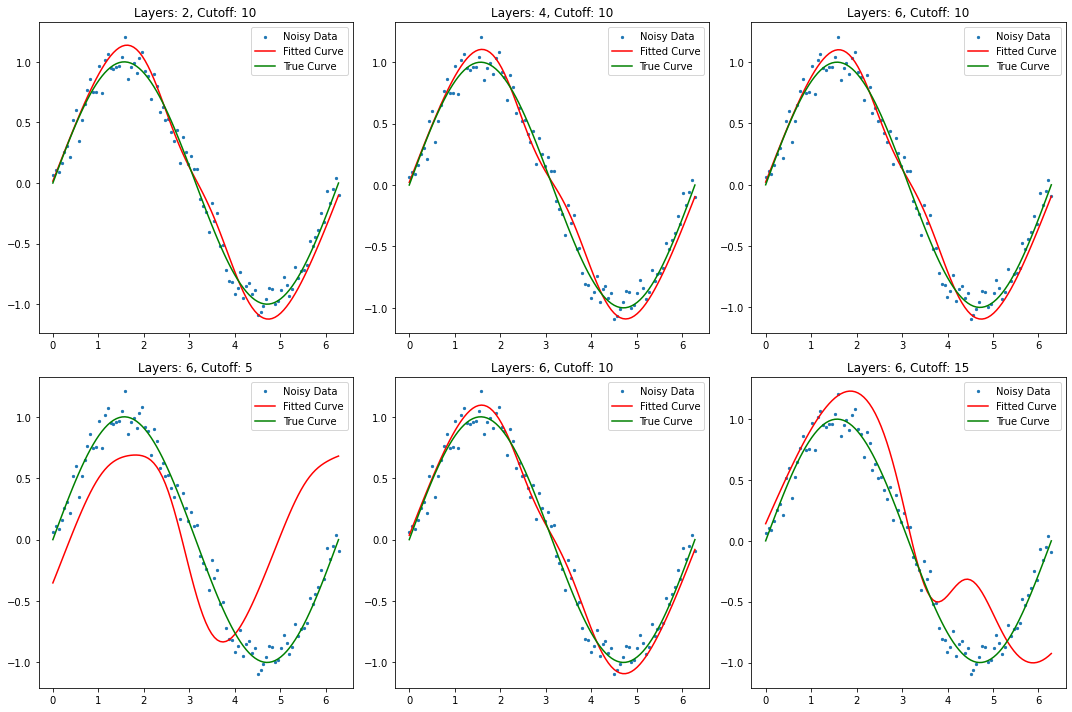

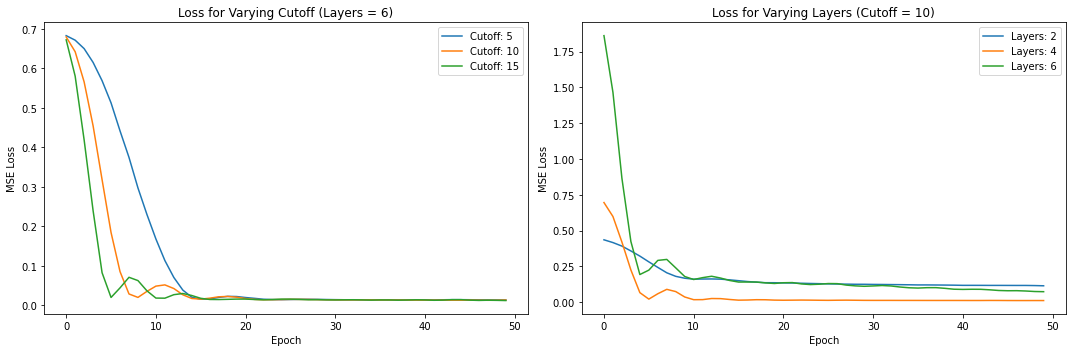

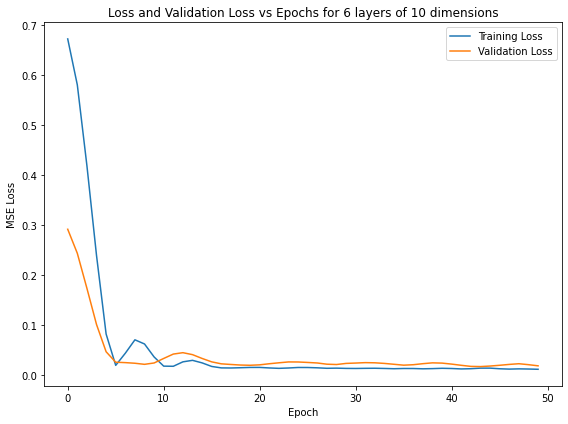

In [10]:
num_layers = 6
cutoff_dim = [5, 10, 15] 

# Generate sine wave data
num_points = 100
x_data = np.linspace(0, 2 * np.pi, num_points)
y_data = np.sin(x_data)

# Add noise
noise_level = 0.1
y_data_noisy = y_data + noise_level * np.random.randn(num_points)

# Reshape for the model
x_data = x_data.astype(np.complex64).reshape(-1, 1)
y_data_noisy = y_data_noisy.astype(np.float32).reshape(-1, 1)

configs = [
    (2, 50),
    (4, 50),
    (6, 50)
]

trained_models, histories = train_models(x_data, y_data_noisy, configs = configs)
trained_models2, histories2 = train_models(x_data, y_data_noisy, cutoff_dim = cutoff_dim)

trained_models += trained_models2
histories += histories2

plot_results(trained_models, histories, configs, cutoff_dim, x_data, y_data, y_data_noisy)